In [1]:
!pip install ripser
!pip install transformers
!pip install pandas
!pip install datasets


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!ls

Modified_TDA_vs_Linguistic_features.ipynb  datasets  test_data


TDA Feature Extractor with BERT Embedding


In [3]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
import ripser
from ripser import ripser
from tqdm import tqdm
import math

import numpy as geek


In [4]:

def find_highest_finite_value_comprehension(data):
    """Finds the highest value in a list, ignoring inf values, using list comprehension."""
    finite_values = [x for x in data if not math.isinf(x)]
    return max(finite_values) if finite_values else -math.inf


def get_second_value_ignoring_inf(data):
    """
    Returns the second non-inf value in a list.

    Args:
      data: A list of numerical values.

    Returns:
      The second non-inf value in the list, or None if not found.
    """
    non_inf_values = [x for x in data if not math.isinf(x)]
    if len(non_inf_values) < 2:
        return None
    return non_inf_values[1]



In [5]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
import networkx as nx
from ripser import ripser

def get_bert_attention(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    attention_matrices = torch.stack(outputs.attentions).mean(dim=0).squeeze().numpy()
    return np.mean(attention_matrices, axis=0)  # Averaging across heads

def build_graph(attention_matrix, threshold=0.1):
    graph = nx.Graph()
    num_nodes = attention_matrix.shape[0]

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if attention_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=attention_matrix[i, j])

    return graph

def compute_tda_features(graph):
    adjacency_matrix = nx.to_numpy_array(graph)
    diagrams = ripser(adjacency_matrix, maxdim=1)['dgms']


    h0 = diagrams[0]
    h1 = diagrams[1] if len(diagrams) > 1 else np.array([])

    num_h0 = geek.count_nonzero(np.round(h0)) #count_nonzero(h0) #len(h0)
    highest_h0 = find_highest_finite_value_comprehension(h0[:, 1] - h0[:, 0]) if num_h0 > 0 else 0
    Second_highest_h0 = get_second_value_ignoring_inf(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else 0
    highest_minus_second_h0 = highest_h0 - Second_highest_h0 if num_h0 > 1 else 0

    # Replace inf values with 0
    h0[np.isinf(h0)] = 0
    mean_h0 = np.mean(h0) if num_h0 > 0 else 0
    # print("mean h0: ", mean_h0)


    num_h1 = geek.count_nonzero(np.round(h1))
    highest_h1 = find_highest_finite_value_comprehension(h1[:, 1] - h1[:, 0]) if num_h1 > 0 else 0
    second_highest_h1 = get_second_value_ignoring_inf(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else 0
    highest_minus_second_h1 = highest_h1 - second_highest_h1 if num_h1 > 1 else 0

    # Replace inf values with 0
    h1[np.isinf(h1)] = 0
    mean_h1 = np.mean(h1) if num_h1 > 0 else 0
    # print("mean h1: ", mean_h1)

    h0_persistences = np.sort(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else np.array([0])

    h1_persistences = np.sort(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else np.array([0])

    # Additional TDA features for linguistic correlation
    sum_persistence_0 = np.sum(h0_persistences) if len(h0_persistences) > 0 else 0
    sum_persistence_1 = np.sum(h1_persistences) if len(h1_persistences) > 0 else 0
    persistence_entropy_0 = -np.sum(h0_persistences * np.log(h0_persistences + 1e-10)) if len(h0_persistences) > 0 else 0
    persistence_entropy_1 = -np.sum(h1_persistences * np.log(h1_persistences + 1e-10)) if len(h1_persistences) > 0 else 0
    betti_curve_0 = len(h0_persistences)
    betti_curve_1 = len(h1_persistences)


    return [num_h0, highest_h0, highest_minus_second_h0, mean_h0, betti_curve_0, persistence_entropy_0,
            num_h1, highest_h1, highest_minus_second_h1, mean_h1, betti_curve_1, persistence_entropy_1]

def process_texts(texts):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    data = []
    for text in tqdm(texts):
        attention_matrix = get_bert_attention(text, model, tokenizer)
        graph = build_graph(attention_matrix)
        tda_features = compute_tda_features(graph)
        data.append(tda_features)

    columns = ["Num_0dim", "Max_0dim", "Max_0dim_Minus_Second", "Mean_0dim", "betti_curve_0", "persistence_entropy_0",
               "Num_1dim", "Max_1dim", "Max_1dim_Minus_Second", "Mean_1dim", "betti_curve_1", "persistence_entropy_1"]
    return pd.DataFrame(data, columns=columns)

# Example usage
texts = ["This is a test sentence.", "Another example of text processing."]
df = process_texts(texts)
print(df)


  0%|          | 0/2 [00:00<?, ?it/s]BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
 50%|█████     | 1/2 [00:00<00:00,  2.91it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

   Num_0dim  Max_0dim  Max_0dim_Minus_Second  Mean_0dim  betti_curve_0  \
0         2  0.763828               0.684179   0.099308              8   
1         2  1.240708               1.123605   0.120323              8   

   persistence_entropy_0  Num_1dim  Max_1dim  Max_1dim_Minus_Second  \
0               1.690237         0         0                      0   
1               1.194267         0         0                      0   

   Mean_1dim  betti_curve_1  persistence_entropy_1  
0          0              1                   -0.0  
1          0              1                   -0.0  


Datasets

In [6]:
import pandas as pd

# datasets[0]: BLIMP; ...
datasets = ["/workspace/tda_vs_linguistic/TDA_linguistic_tests/datasets/nyu_mll_blimp.csv", "/workspace/tda_vs_linguistic/TDA_linguistic_tests/datasets/nyu_winograd_wsc.csv"]
dataset = datasets[0]

# automatically change name of data stored
dataset_name = ""
label_good = ""
label_bad = ""
title1 = ""
title2 = ""
if dataset == datasets[0]:
    dataset_name = "BLIMP"
    label_good = "sentence_good"
    label_bad = "sentence_bad"
    title1 = "Gramatically Correct Sentences"
    title2 = "Gramatically Incorrect Sentences"
elif dataset == datasets[1]:
    dataset_name = "winograd"
    label_good = "sentence1"
    label_bad = "sentence2"
    title1 = "Sentences Referencing Sooner Tokens"
    title2 = "Sentences Referencing Later Tokens"

data_sen_pairs = pd.read_csv(dataset)

In [7]:
data_sen_pairs.head()

,sentence_good,sentence_bad,field,linguistics_term,UID,simple_LM_method,one_prefix_method,two_prefix_method,lexically_identical,pair_id
0,Who should Derek hug after shocking Richard?,Who should Derek hug Richard after shocking?,syntax,island_effects,adjunct_island,True,False,False,True,0
1,What had Theresa walked through while talking ...,What had Theresa walked through that high scho...,syntax,island_effects,adjunct_island,True,False,False,True,1
2,Who will Katherine discover without hiring Erin?,Who will Katherine discover Erin without hiring?,syntax,island_effects,adjunct_island,True,False,False,True,2
3,Who has Colleen aggravated before kissing Judy?,Who has Colleen aggravated Judy before kissing?,syntax,island_effects,adjunct_island,True,False,False,True,3
4,What could a lot of cats break while finding a...,What could a lot of cats break all convertible...,syntax,island_effects,adjunct_island,True,False,False,True,4


In [8]:
sen_good = data_sen_pairs[label_good][0:500]
sen_bad = data_sen_pairs[label_bad][0:500]

In [9]:
good_tda = process_texts(sen_good)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  0%|          | 1/500 [00:00<04:10,  1.99it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  0%|          | 2/500 [00:00<04:07,  2.01it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  1%|          | 3/500 [00:01<04:06,  2.02it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that t

In [10]:
good_tda

,Num_0dim,Max_0dim,Max_0dim_Minus_Second,Mean_0dim,betti_curve_0,persistence_entropy_0,Num_1dim,Max_1dim,Max_1dim_Minus_Second,Mean_1dim,betti_curve_1,persistence_entropy_1
0,2,1.407595,1.402626,0.086620,10,0.411330,0,0,0,0,1,-0.0
1,2,1.448208,1.440681,0.067994,14,0.715900,0,0,0,0,1,-0.0
2,2,1.410920,1.407136,0.077435,10,0.007520,0,0,0,0,1,-0.0
3,2,1.406136,1.401259,0.089957,10,0.577210,0,0,0,0,1,-0.0
4,2,1.512659,1.511028,0.065066,15,0.567640,0,0,0,0,1,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,1.331914,1.329646,0.079951,11,0.647279,0,0,0,0,1,-0.0
496,2,1.378825,1.375535,0.073188,12,0.576388,0,0,0,0,1,-0.0
497,2,1.379394,1.367767,0.079920,11,0.622590,0,0,0,0,1,-0.0
498,2,1.421882,1.414514,0.079018,11,0.409987,0,0,0,0,1,-0.0


In [11]:
bad_tda = process_texts(sen_bad)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  0%|          | 1/500 [00:00<01:30,  5.49it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  0%|          | 2/500 [00:00<02:02,  4.08it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  1%|          | 3/500 [00:00<01:53,  4.37it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that t

In [12]:
bad_tda

,Num_0dim,Max_0dim,Max_0dim_Minus_Second,Mean_0dim,betti_curve_0,persistence_entropy_0,Num_1dim,Max_1dim,Max_1dim_Minus_Second,Mean_1dim,betti_curve_1,persistence_entropy_1
0,2,1.394898,1.385995,0.096663,10,0.828451,0,0,0,0,1,-0.0
1,2,1.455996,1.453288,0.066087,14,0.595268,0,0,0,0,1,-0.0
2,2,1.371830,1.370685,0.086011,10,0.475064,0,0,0,0,1,-0.0
3,2,1.389654,1.333002,0.107224,10,1.250774,0,0,0,0,1,-0.0
4,2,1.516971,1.514745,0.078422,15,1.323001,0,0,0,0,1,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,1.342289,1.338003,0.088041,11,0.951861,0,0,0,0,1,-0.0
496,2,1.390647,1.389310,0.065597,12,0.200015,0,0,0,0,1,-0.0
497,2,1.371782,1.365961,0.069485,11,0.149098,0,0,0,0,1,-0.0
498,2,1.420193,1.418224,0.078762,11,0.315000,0,0,0,0,1,-0.0


In [13]:
# changed to save in files
good_tda.to_csv(f"/workspace/tda_vs_linguistic/TDA_linguistic_tests/test_data/{dataset_name}/{dataset_name}_good_tda.csv", index=False)
bad_tda.to_csv(f"/workspace/tda_vs_linguistic/TDA_linguistic_tests/test_data/{dataset_name}/{dataset_name}_bad_tda.csv", index=False)

Linguistic Features

In [14]:
!pip install textdescriptives
!pip install spacy
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 142.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
import spacy
import textdescriptives as td
# load your favourite spacy model (remember to install it first using e.g. `python -m spacy download en_core_web_sm`)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textdescriptives/all")


In [16]:
def get_desc(data):
  doc = nlp(data.iloc[0])
  df1 = td.extract_df(doc)

  for text in tqdm(data.iloc[1:]):
    text = nlp(text)
    df2 = td.extract_df(text)
    df1 = df1._append(df2)

  return df1

In [17]:
good_feat = get_desc(sen_good)

100%|██████████| 499/499 [00:03<00:00, 130.93it/s]


In [18]:
bad_feat = get_desc(sen_bad)

100%|██████████| 499/499 [00:03<00:00, 144.48it/s]


In [19]:
# save both
good_feat.to_csv(f"/workspace/tda_vs_linguistic/TDA_linguistic_tests/test_data/{dataset_name}/{dataset_name}_good_feat.csv", index=False)
bad_feat.to_csv(f"/workspace/tda_vs_linguistic/TDA_linguistic_tests/test_data/{dataset_name}/{dataset_name}_bad_feat.csv", index=False)

In [20]:
bad_feat.head()

,text,pos_prop_ADJ,pos_prop_ADP,pos_prop_ADV,pos_prop_AUX,pos_prop_CCONJ,pos_prop_DET,pos_prop_INTJ,pos_prop_NOUN,pos_prop_NUM,...,top_ngram_chr_fraction_3,top_ngram_chr_fraction_4,oov_ratio,dependency_distance_mean,dependency_distance_std,prop_adjacent_dependency_relation_mean,prop_adjacent_dependency_relation_std,entropy,perplexity,per_word_perplexity
0,Who should Derek hug Richard after shocking?,0.125000,0.125000,0.0,0.125000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,None,1.875000,0.0,0.375000,0.0,0.046587,1.047689,0.130961
0,What had Theresa walked through that high scho...,0.083333,0.166667,0.0,0.083333,0.0,0.083333,0.0,0.083333,0.0,...,0.0,0.0,None,2.500000,0.0,0.416667,0.0,0.131019,1.139990,0.094999
0,Who will Katherine discover Erin without hiring?,0.000000,0.125000,0.0,0.125000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,None,1.750000,0.0,0.375000,0.0,0.049489,1.050734,0.131342
0,Who has Colleen aggravated Judy before kissing?,0.000000,0.125000,0.0,0.125000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,None,1.500000,0.0,0.500000,0.0,0.049688,1.050943,0.131368
0,What could a lot of cats break all convertible...,0.000000,0.083333,0.0,0.083333,0.0,0.166667,0.0,0.250000,0.0,...,0.0,0.0,None,2.333333,0.0,0.416667,0.0,0.210934,1.234831,0.102903


In [21]:
bad_feat['smog']

0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
     ..
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
Name: smog, Length: 500, dtype: float64

In [22]:
focus_good_feat = good_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens']]

focus_bad_feat = bad_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens']]

In [23]:
focus_tda_good = good_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]
focus_tda_bad = bad_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]

Corelation

In [24]:
!pip install dcor


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [25]:
from dcor import distance_correlation

# did not work will troubleshoot
# corr_value = distance_correlation(df_scores.to_numpy(), focus_feat.to_numpy())
# print("Distance Correlation:", corr_value)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


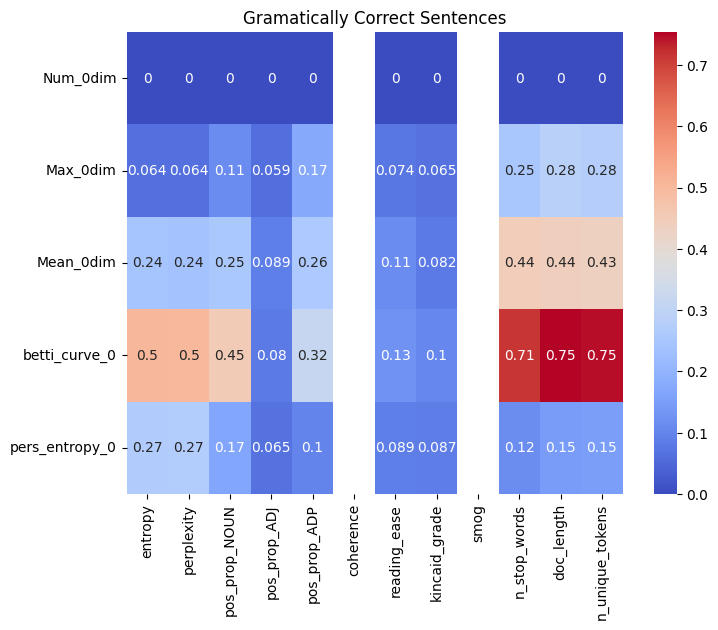

In [26]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
import numpy as np

# # Example: Assume we have multiple TDA and linguistic features
# tda_features = np.random.rand(100, 6)  # 6 TDA features (replace with real data)
# linguistic_features = np.random.rand(100, 4)  # 4 linguistic features (replace with real data)
tda_features = focus_tda_good.to_numpy()
linguistic_features = focus_good_feat.to_numpy()

# Compute pairwise distance correlation matrix
corr_matrix = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            xticklabels= ['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"]
            )


plt.title(f"{title1}")

plt.savefig(f"/workspace/tda_vs_linguistic/TDA_linguistic_tests/test_data/{dataset_name}/{dataset_name}_sen_good.pdf")
plt.show()

#Distance Correlation Heatmap

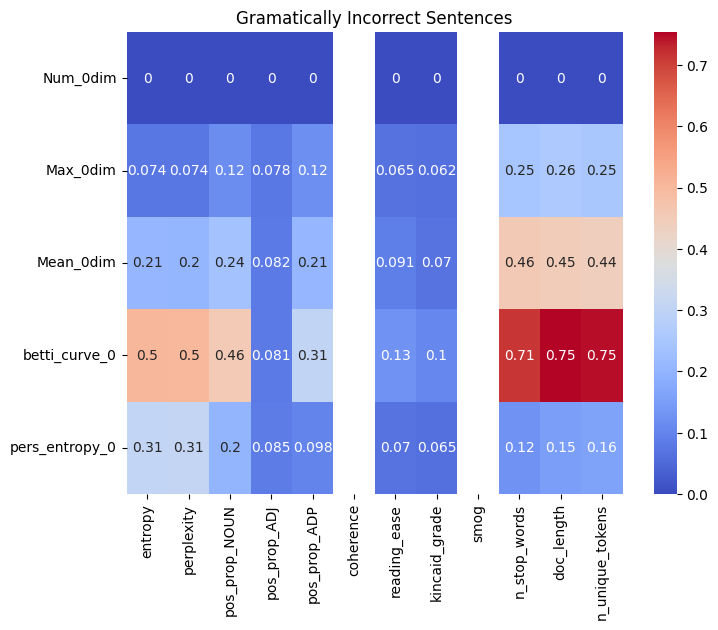

In [27]:
tda_features = focus_tda_bad.to_numpy()
linguistic_features = focus_bad_feat.to_numpy()

# Compute pairwise distance correlation matrix
corr_matrix = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            xticklabels= ['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"]
            )
plt.title(f"{title2}")

plt.savefig(f"/workspace/tda_vs_linguistic/TDA_linguistic_tests/test_data/{dataset_name}/{dataset_name}_sen_bad.pdf")
plt.show()

TDA Feature Extractor with Attention matrix

In [28]:
# # not sure what is doing
# df_scores_at = process_texts(data_test['text'].iloc[0:20])

In [29]:
# # also not sure what is doing
# df_scores_at.head()

In [30]:
# again not sure where df_scores_at comes from :''(
# focus_tda_at = df_scores_at[['Num_0dim', 'Max_0dim', 'Max_0dim_Minus_Second', 'Mean_0dim']]